In [1]:
import torch
from jackpot import Jackpot

import matplotlib as mpl 
mpl.rcParams["font.family"] = "DejaVu Sans"

params = {
    "experiment_name": "jmlr_blind_inverse_problem",
    "save_plot": True,
    "n_singular_pairs": 8,
    "max_compute_time": 3600,
    "load_sing_pairs": False,
    "save_sing_pairs": True,
    "D": 2,
    "epsilon": 1e-1,
    "n_points_per_axis": 5,
    "grid_length": 1e-1,
    "load_manifold": False,
    "save_manifold": True,
}

# ------------------------------------
#  DIRECT MODEL 
# ------------------------------------
import matplotlib.pyplot as plt
from pathlib import Path

import deepinv as dinv

######## IMPORT THE MODEL #################################
from article_examples.blind_inv_pb.deblur_simple import Deblurring

import imageio.v3 as iio

# Device & dtype setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64
factory_kwargs = {"device": device, "dtype": dtype}
torch.manual_seed(0)

# Example: Blind inverse problem
img_size = 400
image_filename = "blob3.jpg"
max_iter_DPIR = 10
i_max_zernike = 12
psf_size = 51

num_workers = 8
batch_size = 1

PATH = Path("./dataset/")
image_name = image_filename[:-4]
img_filename = PATH / Path(image_filename)

def load_image(img_name, img_size = None):
    im = iio.imread(img_name)
    if len(im.shape) == 2:
        im = im[:,:,None]
    
    im = (torch.tensor(im, device = device, dtype = dtype)[:,:,:3] *  
            torch.ones((1,1,3), device = device, dtype = dtype)) /255
    im = im.permute((2,0,1))[None,...]
    
    if img_size != None:
        im = im[:,:,:img_size,:img_size]
    
    return im

x = load_image(img_filename, img_size = img_size)

deblur_model = Deblurring(device = device, dtype = dtype)
deblur_model.set_variables(img_size = img_size, batch_size = batch_size,
                           num_workers = num_workers, max_iter_DPIR = max_iter_DPIR,
                           i_max_zernike = i_max_zernike, psf_size = psf_size)

x, x_est, y = deblur_model.generate_random_coeffs(x = x)

sigma_noise = deblur_model.noise_level_img
deblur_model.set_model(y)
Phi = deblur_model.Phi
estimate = lambda p : deblur_model.deconvolve(y, p)
# ------------------------------------

/home/munier/python_envs/jackpot_env/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


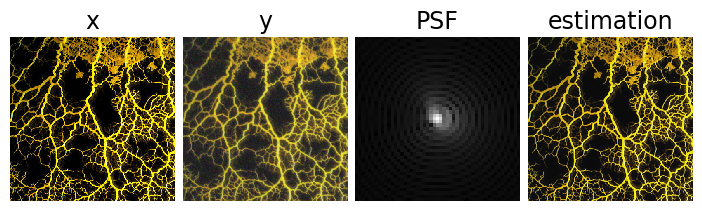

In [2]:
psf_est = deblur_model.psf_from_param(x_est)[None, None, ...]**0.3
dinv.utils.plot({"x": x, "y": y, "PSF": psf_est, "estimation": estimate(x_est)})

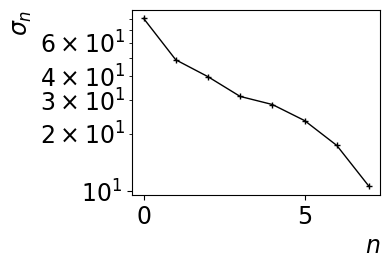

param| pos:[1,2,], iter: 0, loss: 5.338e-01, snr: 43.981, grad: 8.918e+00:   4%|▍         | 1/25 [01:10<24:19, 60.81s/it]

In [ ]:
# ------------------------------------
# JACKPOT INITIALIZATION
# ------------------------------------
jack = Jackpot(Phi, x_est)

jack.set_params(**params)
# ------------------------------------


# ------------------------------------
# JACOBIAN SINGULAR SPECTRUM
# ------------------------------------
jack.jacobian_spectrum()

# Plot spectrum
jack.jacobian_spectrum_plot()
# ------------------------------------


# ------------------------------------
# JACKPOT MANIFOLD
# ------------------------------------
jack.manifold()

# Plot discrepancy
jack.plot_discrepancy(
    in_SNR=True,
    levels=[20, 30, 40],
    color_levels=["g", "b", "r"]
)
# ------------------------------------

In [ ]:
results = jack.get_results()

## Here is the 2D jackpot manifold:

In [ ]:
for j in range(results.shape[1]):
    outs = {f"result {i},{j}": estimate(results[i,j].to(device)) 
            for i in range(results.shape[0])}
    dinv.utils.plot(outs)

## Plots of the 2D jackpot manifold for a detail on the image:

In [ ]:
for j in range(results.shape[1]):
    outs_cropped = {f"result {i},{j}": estimate(results[i,j].to(device))[:, :, -160:-80, -160:-80] 
                    for i in range(results.shape[0])}
    dinv.utils.plot(outs_cropped)

## Plots of the 2D jackpot manifold for the PSF:

In [ ]:
for j in range(results.shape[1]):
    psfs = {f"PSF {i},{j}": 
            deblur_model.psf_from_param(results[i,j].to(device))[None, None, ...]**0.3 
            for i in range(results.shape[0]) }
    dinv.utils.plot(psfs)